## Data description: legacy effects of 10x the same parent

Author: Karin van der Wiel, 10-08-2022

Aim: show the lasting effect of parent


#### Preparation

In [1]:
## import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## data locations
output_directory='/net/pc170544/nobackup/users/wiel/LENTIS/datapaper/'

### CASE 1: temperature in De Bilt

In [2]:
VAR = 'tas'
TIME = 'day'
EXP = 'PD'
LOC = '52.3N_4.9E'; NAME = 'DeBilt'

#### Open data, compute relevant indices

In [3]:
da = xr.open_dataset(f"{output_directory}/{VAR}_{TIME}_{EXP}_{LOC}.nc")[VAR].load()

# convert units
if VAR == 'tas':    da = da - 273.15; da.attrs['units'] = 'deg C'
elif VAR == 'pr':   da = da * 86400; da.attrs['units'] = 'mm/d'  

# compute variability along time (running st.dev. per parent, average over all parents)
da_ens_variability = da.std(dim='member').mean(dim='parent') # only dimension time left
years = np.unique(da.time.dt.year.values)

#### Plot figure

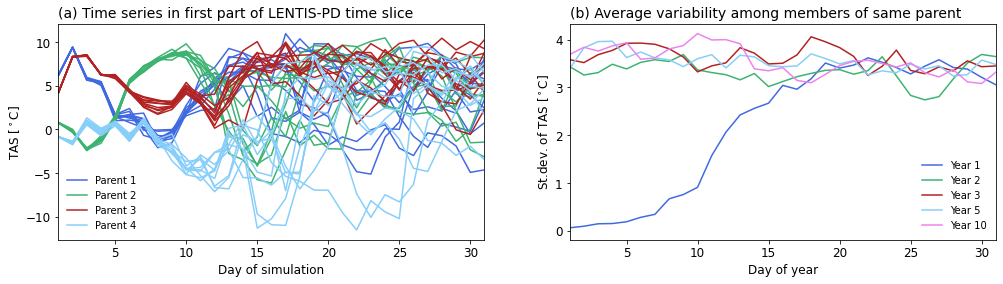

In [4]:
N_days = 31
colours = {1:'royalblue', 2:'mediumseagreen', 3:'firebrick',4:'lightskyblue',5:'violet'}
ylabel = {'tas':'TAS [$^\circ$C]','pr':'PR [mm/d]'}

fig,ax1 = plt.subplots(figsize=(14,4))
plt.subplots_adjust(left=0.05, bottom=0.15, right=.98, top=0.9, hspace=.4)

ax = plt.subplot(1,2,1)
for i_p,P in enumerate([1,2,3,4]):
    for i_m,M in enumerate(da.member):
        plt.plot(np.arange(1,N_days+1),da[i_p,i_m,0:N_days],color=colours[i_p+1])
    plt.plot([-10],da[i_p,i_m,0],color=colours[i_p+1],label=f"Parent {P}")
plt.xlabel('Day of simulation',fontsize=12)
plt.ylabel(ylabel[VAR],fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.xlim(1,N_days)
plt.title(f"(a) Time series in first part of LENTIS-{EXP} time slice",loc='left',fontsize=14)
plt.legend(fontsize=10,frameon=False)

ax = plt.subplot(1,2,2)
for i_y,Y in enumerate([1,2,3,5,10]):
    plt.plot(da_ens_variability.where(da_ens_variability['time.year'] == years[Y-1], drop=True)[0:N_days+1],color=colours[i_y+1],label=f"Year {Y}")
plt.xlabel('Day of year',fontsize=12)
plt.ylabel(f"St.dev. of {ylabel[VAR]}",fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.xlim(1,N_days)
plt.title('(b) Average variability among members of same parent',loc='left',fontsize=14)
plt.legend(fontsize=10,frameon=False)

plt.savefig(f"fig_datadescr_parentleg_{NAME}_{VAR}.pdf")
plt.show()

### CASE 2: ENSO variability

In [5]:
VAR = 'tos'
TIME = 'Omon'
EXP = 'PD'
LOC = 'nino34'; NAME = LOC

#### Open data, compute relevant indices

In [6]:
da = xr.open_dataset(f"{output_directory}/{VAR}_{TIME}_{EXP}_{LOC}.nc")[VAR].load()

# climatology, based on last 5 years of ensemble
tmp = da.where(da.time.dt.year>2004,drop=True)
da_clim = tmp.groupby(tmp.time.dt.month).mean(dim=['parent','member','time'])
del tmp
# anomalies
da_anom = da.groupby(da.time.dt.month) - da_clim
# annual average
da_y = da_anom.groupby(da.time.dt.year).mean(dim='time')

# compute variability along time (running st.dev. per parent, average over all parents)
da_ens_variability = da_y.std(dim='member').mean(dim='parent') # only dimension time left

#### Plot figure

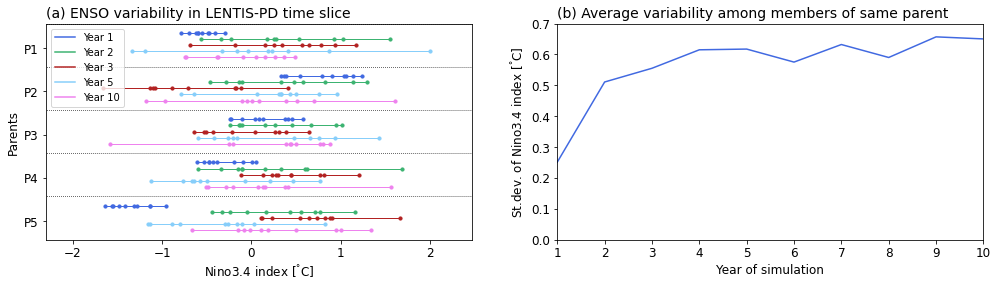

In [7]:
fig,ax1 = plt.subplots(figsize=(14,4))
plt.subplots_adjust(left=0.05, bottom=0.15, right=.98, top=0.9, hspace=.4)

ax = plt.subplot(1,2,1)
ylabels = np.repeat('    ',len(da.parent))
for i_p,P in enumerate([1,2,3,4,5]):
    for i_y,Y in enumerate([1,2,3,5,10]):
        data = da_y.where(da_y.year==years[Y-1], drop=True).where(da_y.parent==P, drop=True)
        plt.scatter(data,np.repeat(P*7+i_y+1,len(da_y.member.values)),s=10,color=colours[i_y+1])
        plt.plot([data.min(),data.max()],np.repeat(P*7+i_y+1,2),linewidth=1,color=colours[i_y+1])
    plt.plot([-5,5],np.repeat(P*7-.5,2),color='black',linewidth=.75,linestyle=':')
    ylabels[i_p] = f"P{P}"
for i_y,Y in enumerate([1,2,3,5,10]):   
    plt.plot(-5,-5,color=colours[i_y+1],label=f"Year {Y}")
plt.yticks(da.parent*7+3.5,ylabels)
plt.xlabel('Nino3.4 index [$^\degree$C]',fontsize=12)
plt.ylabel('Parents',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.xlim(da_y.min()-.1,da_y.max()+.1)
plt.ylim((P+1)*7-.5,6.5)
plt.title(f"(a) ENSO variability in LENTIS-{EXP} time slice",loc='left',fontsize=14)
plt.legend(fontsize=10,frameon=True)

ax = plt.subplot(1,2,2)
plt.plot(np.arange(1,10+1),da_ens_variability,color=colours[1])
plt.xlabel('Year of simulation',fontsize=12)
plt.ylabel(f"St.dev. of Nino3.4 index [$^\degree$C]",fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.xlim(1,10)
plt.ylim(0,np.ceil(da_ens_variability.max()*10)/10)
plt.title('(b) Average variability among members of same parent',loc='left',fontsize=14)

plt.savefig(f"fig_datadescr_parentleg_{NAME}.pdf")
plt.show()